In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *

2024-07-31 11:23:45.923996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
p = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_250_1000_100.0_10000.pkl'
dataset_list, param_dict = load_dataset(p)

In [45]:
dataset_idx = 0

In [46]:
# Unpack the param dict
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
weight_dist = param_dict['weights_dist']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

# Generate variables for the optimization
template_list = dataset_list[dataset_idx]['template_chain_list']
X = dataset_list[dataset_idx]['observation_list']
label_list = dataset_list[dataset_idx]['labels']
observation_flatten_list = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
true_weights = true_weights.reshape(-1, 1)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

In [5]:
# umap observation flatten list
from umap import UMAP

In [6]:
# save dir 
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240730'

In [47]:
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(observation_flatten_list)

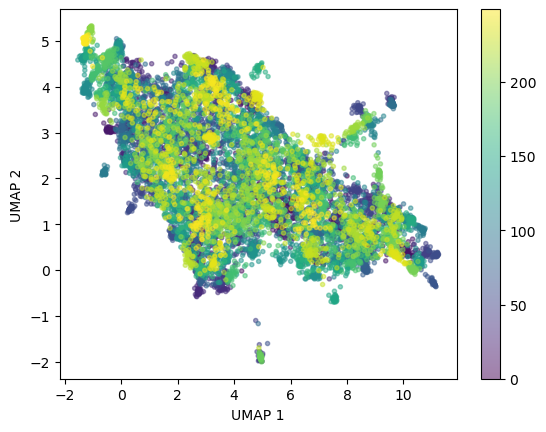

In [48]:
# plot umap projection 
plt.scatter(x=X_umap[:, 0], y=X_umap[:, 1], c=label_list, marker='.', alpha=0.5)
plt.colorbar()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(os.path.join(save_dir, 'umap_observation_250_100.png'))

In [49]:
# Try BGMM on this 
from sklearn.mixture import BayesianGaussianMixture

In [51]:
bgmm = BayesianGaussianMixture(n_components=500, 
                               covariance_type='diag',
                               random_state=0,
                               init_params='k-means++',
                               n_init=1,
                               tol=1e-6)
bgmm.fit(observation_flatten_list)

BayesianGaussianMixture(covariance_type='diag', init_params='k-means++',
                        n_components=500, random_state=0, tol=1e-06)

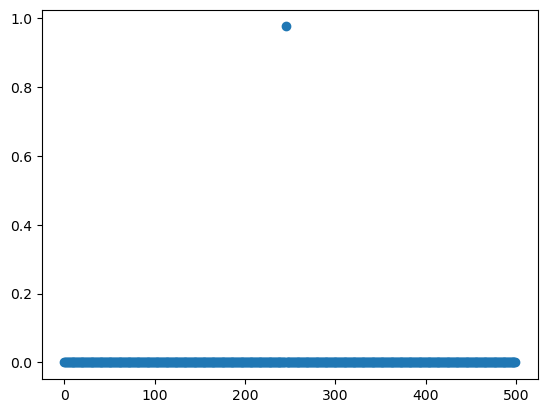

: 

In [26]:
observations_dmap = np.array([squareform(pdist(x)) for x in X])

In [27]:
templates_dmap = np.array([squareform(pdist(x)) for x in template_list])

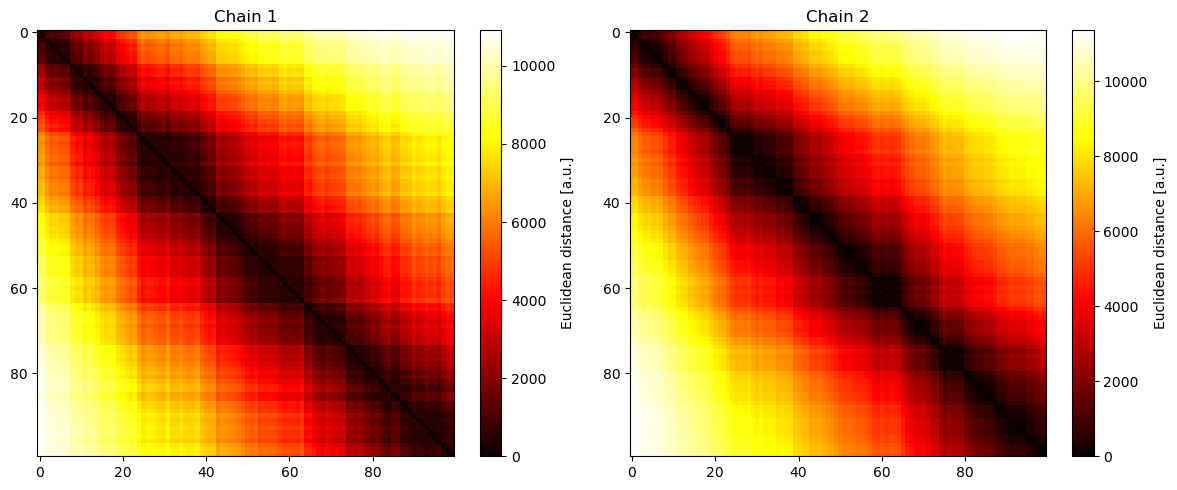

In [31]:
compare_distance_maps(np.median(observations_dmap[label_list==2, :, :], axis=0), templates_dmap[2])

In [41]:
np.linalg.norm(np.median(observations_dmap[label_list==3, :, :], axis=0) - templates_dmap[3])

7586.377991777829

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
cosine_similarity(np.median(observations_dmap[label_list==3, :, :], axis=0).reshape(1, -1), templates_dmap[1].reshape(1, -1))

array([[0.99266899]])

In [23]:
label_list

array([  0,   0,   0, ..., 499, 499, 499])

In [35]:
# Generate a new model 
num_observations = 100 
gaussian_noise_std = 1000
new_template_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for x in range(12)]
new_template_flatten = [squareform(pdist(x)).flatten() for x in new_template_list]
new_observation_list = [generate_observations(x, num_observations, gaussian_noise_std) for x in new_template_list]
new_observation_list = np.concatenate([*new_observation_list])
labels_true = [i for i in range(12) for j in range(num_observations)]
new_observation_flatten = [squareform(pdist(x)).flatten() for x in new_observation_list]

Text(0, 0.5, 'UMAP 2')

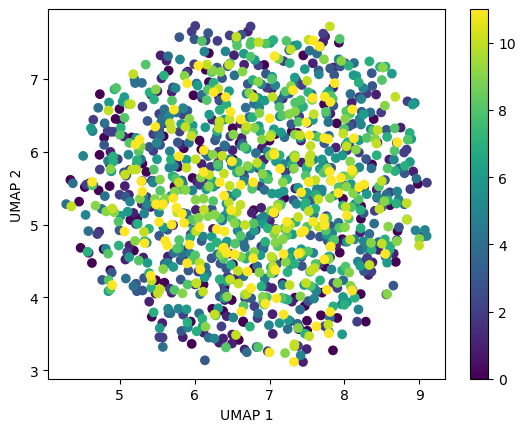

In [37]:
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(new_observation_flatten)
plt.scatter(x=X_umap[:, 0], y=X_umap[:, 1], c=labels_true)
plt.colorbar()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

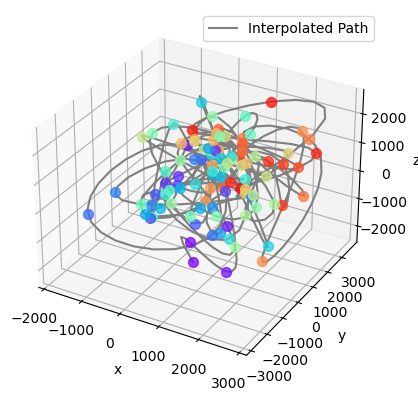

In [40]:
visualize_polymer(new_observation_list[0])

In [44]:
new_observation_dmap = [squareform(pdist(x)) for x in new_observation_list]

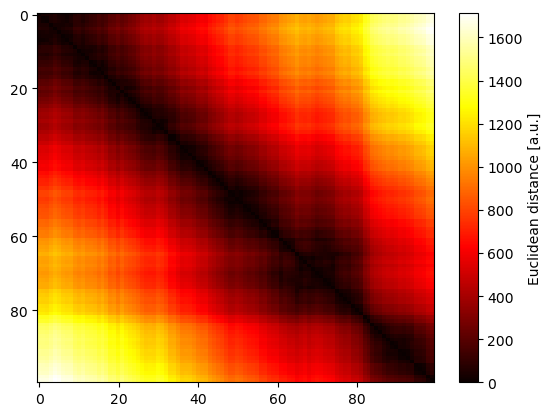

In [46]:
visualize_dmap(squareform(pdist(template_list[0])))

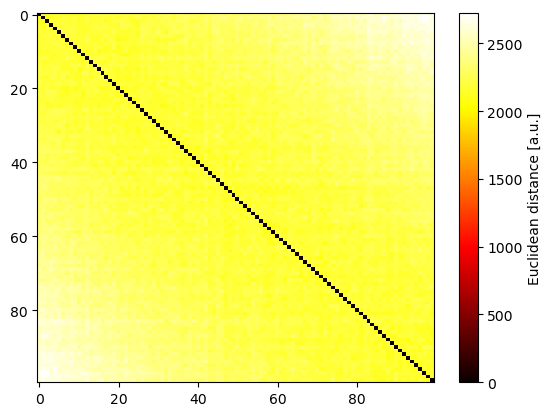

In [45]:
visualize_dmap(np.median(new_observation_dmap, axis=0))